<a href="https://colab.research.google.com/github/johnnfujita/tensorflow_certificate_prep/blob/main/dnn_for_timeseries_single_layer_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5


series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000



In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
l_0 = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.models.Sequential([l_0])

In [ ]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)
print("Layer weights{}".format(l_0.get_weights()))

Layer weights[array([[-0.01473984],
       [ 0.01327908],
       [-0.06828497],
       [ 0.00587891],
       [ 0.07445447],
       [ 0.05329583],
       [-0.041001  ],
       [-0.05228669],
       [ 0.03431874],
       [-0.03805605],
       [ 0.04657792],
       [ 0.02166223],
       [-0.10423563],
       [ 0.04551996],
       [ 0.05036958],
       [ 0.05167388],
       [ 0.01066162],
       [ 0.19570109],
       [ 0.33641818],
       [ 0.36818174]], dtype=float32), array([0.01432567], dtype=float32)]


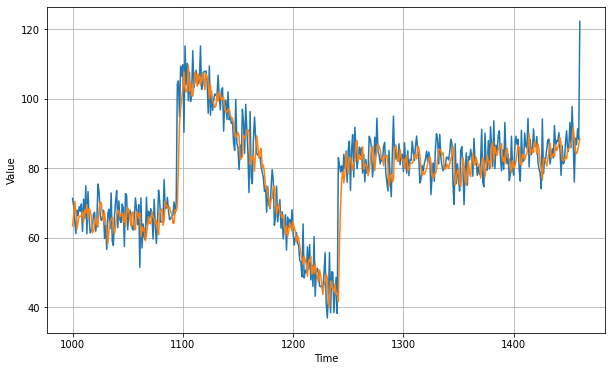

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid,results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9448385

In [ ]:
# With dnn

In [ ]:
model_2 = tf.keras.models.Sequential([
                                      tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
                                      tf.keras.layers.Dense(10, activation="relu"),
                                      tf.keras.layers.Dense(1)
])

model_2.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model_2.fit(dataset, epochs=100, verbose=0)


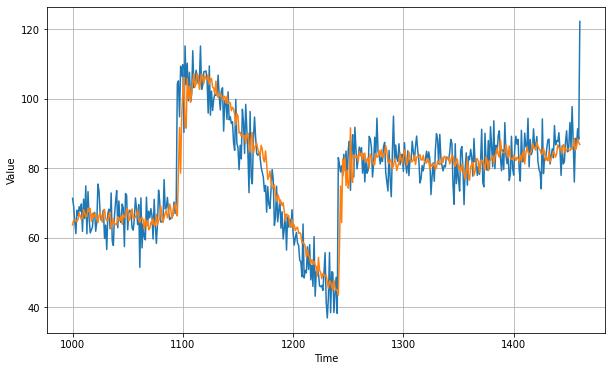

In [ ]:
forecast_2 = []
for time in range(len(series) - window_size):
  forecast_2.append(model_2.predict(series[time:time + window_size][np.newaxis]))

forecast_2 = forecast_2[split_time-window_size:]
results_2 = np.array(forecast_2)[:,0,0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid,results_2)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results_2).numpy()

5.0439267

In [ ]:
### WITH DNN and adjusting the learning rate

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                      tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
                                      tf.keras.layers.Dense(10, activation="relu"),
                                      tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

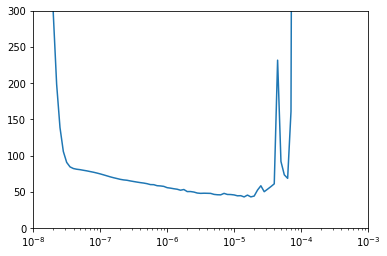

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [ ]:
window_size = 30

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                      tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
                                      tf.keras.layers.Dense(10, activation="relu"),
                                      tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500,  verbose=0)


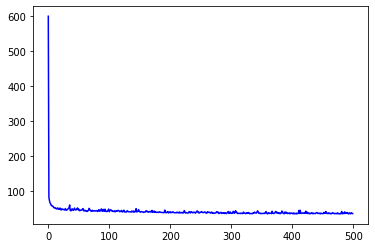

In [ ]:
loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label="Training Loss")
plt.show()

[258.74066162109375, 254.48609924316406, 250.5488739013672, 247.3072052001953, 244.23300170898438, 241.51498413085938, 238.86093139648438, 236.45164489746094, 234.24114990234375, 232.23548889160156, 230.31187438964844, 228.57130432128906, 226.86508178710938, 225.21067810058594, 223.65745544433594, 222.1746368408203, 220.72169494628906, 219.4269561767578, 218.11599731445312, 216.8521728515625, 215.54893493652344, 214.3841552734375, 213.2136688232422, 212.0941162109375, 211.02236938476562, 210.02456665039062, 209.01121520996094, 208.07662963867188, 207.14149475097656, 206.2116241455078, 205.34188842773438, 204.45672607421875, 203.62179565429688, 202.75306701660156, 201.93186950683594, 201.10728454589844, 200.3323516845703, 199.54722595214844, 198.8177947998047, 198.07606506347656, 197.35975646972656, 196.67613220214844, 196.01622009277344, 195.32701110839844, 194.68568420410156, 194.0226287841797, 193.40342712402344, 192.7728729248047, 192.17959594726562, 191.5807647705078, 191.024475097

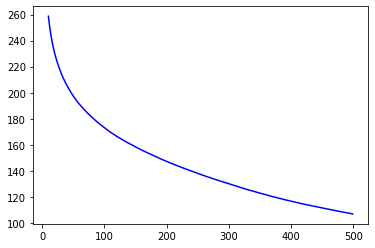

In [ ]:
loss = history.history["loss"]
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, "b", label="Training Loss")
plt.show()

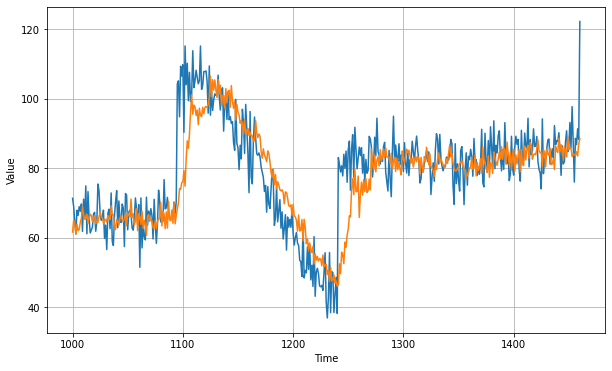

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid,results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.446041

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                    tf.keras.layers.SimpleRNN(40, return_sequences=True),
                                    tf.keras.layers.SimpleRNN(40),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 34ms/step - loss: 194.6263 - mae: 195.1263
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 195.2580 - mae: 195.7580
Epoch 3/100
8/8 [==============================] - 0s 42ms/step - loss: 193.9793 - mae: 194.4793
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 192.3059 - mae: 192.8059
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 189.4673 - mae: 189.9673
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 187.5114 - mae: 188.0114
Epoch 7/100
8/8 [==============================] - 0s 28ms/step - loss: 185.2977 - mae: 185.7977
Epoch 8/100
8/8 [==============================] - 0s 42ms/step - loss: 183.4114 - mae: 183.9114
Epoch 9/100
8/8 [==============================] - 0s 40ms/step - loss: 180.7796 - mae: 181.2796
Epoch 10/100
8/8 [==============================] - 0s 31ms/step - loss: 176.5626 - mae: 177.0626
Epoch 11/100
8/8 [===========

(1e-08, 0.0001, 0.0, 30.0)

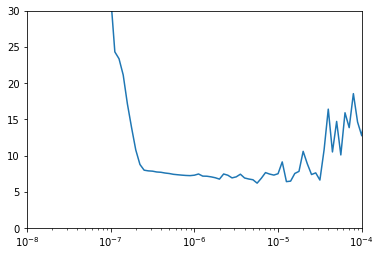

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4,0,30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.Sequential([
                             tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                             tf.keras.layers.SimpleRNN(40, return_sequences=True),
                             tf.keras.layers.SimpleRNN(40),
                             tf.keras.layers.Dense(1),
                             tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 30ms/step - loss: 114.4029 - mae: 114.9029
Epoch 2/400
8/8 [==============================] - 0s 30ms/step - loss: 22.2723 - mae: 22.7646
Epoch 3/400
8/8 [==============================] - 0s 29ms/step - loss: 17.3886 - mae: 17.8839
Epoch 4/400
8/8 [==============================] - 0s 30ms/step - loss: 13.2057 - mae: 13.7009
Epoch 5/400
8/8 [==============================] - 0s 30ms/step - loss: 9.7377 - mae: 10.2270
Epoch 6/400
8/8 [==============================] - 0s 31ms/step - loss: 15.2561 - mae: 15.7504
Epoch 7/400
8/8 [==============================] - 0s 34ms/step - loss: 14.4394 - mae: 14.9318
Epoch 8/400
8/8 [==============================] - 0s 31ms/step - loss: 10.6431 - mae: 11.1345
Epoch 9/400
8/8 [==============================] - 0s 28ms/step - loss: 10.9797 - mae: 11.4747
Epoch 10/400
8/8 [==============================] - 0s 30ms/step - loss: 9.8696 - mae: 10.3546
Epoch 11/400
8/8 [==============================]

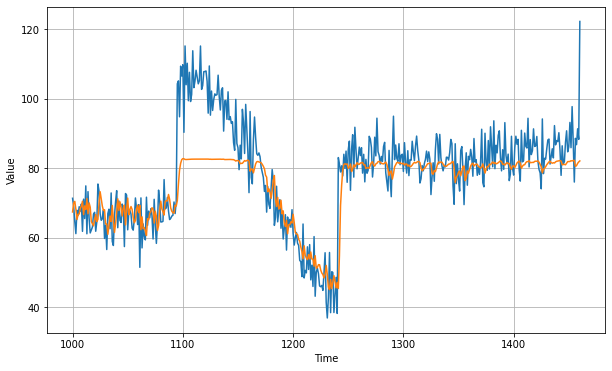

In [12]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]
plt.figure(figsize=[10, 6])
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.7228007

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

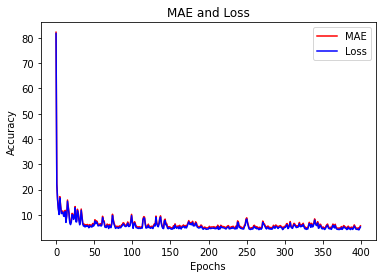

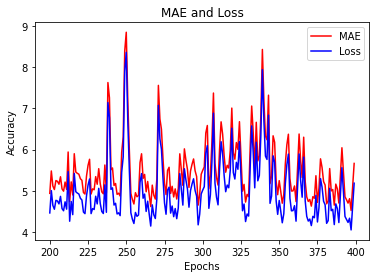

In [16]:
mae = history.history["mae"]
loss=history.history["loss"]

epochs=range(len(loss))

plt.plot(epochs, mae, "r")
plt.plot(epochs,loss, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, "r")
plt.plot(epochs_zoom, loss_zoom, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])



In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                            tf.keras.layers.Dense(1),
                            tf.keras.layers.Lambda(lambda x : x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 **(epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])



Epoch 1/100
31/31 [==============================] - 11s 11ms/step - loss: 21.9679 - mae: 22.4630
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 21.0787 - mae: 21.5699
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 19.9720 - mae: 20.4666
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 20.5891 - mae: 21.0813
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 20.2777 - mae: 20.7735
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 19.6437 - mae: 20.1366
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 18.2940 - mae: 18.7848
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 17.2657 - mae: 17.7576
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 17.4906 - mae: 17.9840
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 16.8689 - mae: 17.3590
Epoch 11/100
31/31 [========

(1e-08, 0.0001, 0.0, 30.0)

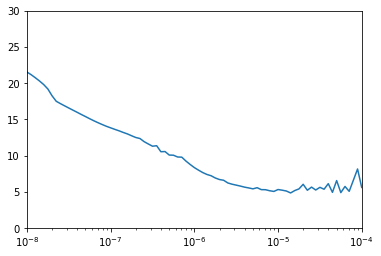

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                            tf.keras.layers.Dense(1),
                            tf.keras.layers.Lambda(lambda x : x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500)



Epoch 1/500
31/31 [==============================] - 5s 10ms/step - loss: 1318.6538
Epoch 2/500
31/31 [==============================] - 0s 10ms/step - loss: 137.8467
Epoch 3/500
31/31 [==============================] - 0s 10ms/step - loss: 97.2104
Epoch 4/500
31/31 [==============================] - 0s 11ms/step - loss: 125.2994
Epoch 5/500
31/31 [==============================] - 0s 10ms/step - loss: 94.8865
Epoch 6/500
31/31 [==============================] - 0s 10ms/step - loss: 104.4612
Epoch 7/500
31/31 [==============================] - 0s 10ms/step - loss: 83.7542
Epoch 8/500
31/31 [==============================] - 0s 10ms/step - loss: 89.9812
Epoch 9/500
31/31 [==============================] - 0s 10ms/step - loss: 68.0641
Epoch 10/500
31/31 [==============================] - 0s 10ms/step - loss: 56.5528
Epoch 11/500
31/31 [==============================] - 0s 10ms/step - loss: 85.8830
Epoch 12/500
31/31 [==============================] - 0s 10ms/step - loss: 59.5057
Epoch 13

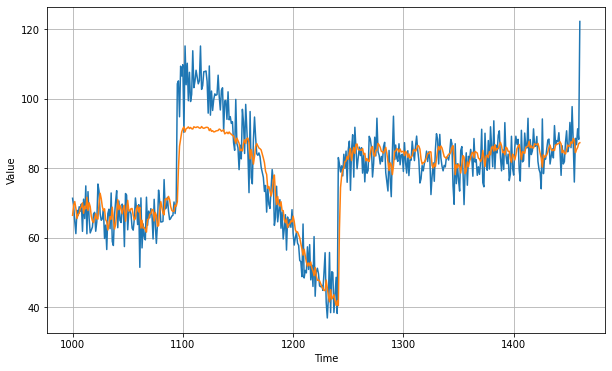

In [16]:
forecast = []
results = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:,0,0]
plt.figure(figsize=[10, 6])
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.524295